# GradCAM Evaluation : CNN

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split

## Load data

In [2]:
# File paths
image_dir = '../images'
labels_df = pd.read_csv('../labels.csv')

# Extract file names and labels
image_filenames = labels_df['Filename'].values
y = labels_df['Label'].values

# Construct full image paths
image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]

# Ensure images and labels are aligned
if len(image_paths) != len(y):
    raise ValueError("Number of images and labels do not match.")

labels_df.head()

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


# Train test split

In [3]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(image_paths, y, test_size=0.2, stratify=y, random_state=42)

# Create label-to-species mapping for displaying label counts
label_to_species = dict(zip(labels_df['Label'], labels_df['Species']))

# Label distribution
def print_label_distribution(y_train, y_test, label_to_species):
    # Create label counts for train and test datasets
    train_label_counts = pd.Series(y_train).value_counts().reset_index()
    test_label_counts = pd.Series(y_test).value_counts().reset_index()

    # Rename columns
    train_label_counts.columns = ['Label', 'Count']
    test_label_counts.columns = ['Label', 'Count']

    # Map species to the label counts
    train_label_counts['Species'] = train_label_counts['Label'].map(label_to_species)
    test_label_counts['Species'] = test_label_counts['Label'].map(label_to_species)

    # Display the distributions
    print("Training dataset distribution:")
    print(train_label_counts.to_string(index=False))

    print("\nTesting dataset distribution:")
    print(test_label_counts.to_string(index=False))

print_label_distribution(y_train, y_test, label_to_species)

Training dataset distribution:
 Label  Count        Species
     8   7285       Negative
     0    900   Chinee apple
     6    859      Siam weed
     1    851        Lantana
     4    849 Prickly acacia
     2    825    Parkinsonia
     3    818     Parthenium
     7    813     Snake weed
     5    807    Rubber vine

Testing dataset distribution:
 Label  Count        Species
     8   1821       Negative
     0    225   Chinee apple
     6    215      Siam weed
     1    213        Lantana
     4    213 Prickly acacia
     2    206    Parkinsonia
     3    204     Parthenium
     7    203     Snake weed
     5    202    Rubber vine


## Dealing with imbalance data

To mitigate class imbalance, I will randomly select Negative instances (Label is 8) to balance with other classes. 
Undersampling will only be performed on the training set to prevent the model from overfitting to the Negative instances. 

In [4]:
# Function to perform undersampling
def undersample_classes(X_train, y_train, target_size=800):
    # Create DataFrame with image paths and corresponding labels
    train_df = pd.DataFrame({'Filename': X_train, 'Label': y_train})
    
    # Initialize empty list to hold undersampled data
    undersampled_df = []

    # Iterate through each class (label)
    for label in np.unique(y_train):
        # Get the subset of data for this class
        class_subset = train_df[train_df['Label'] == label]
        
        # Sample 'target_size' number of images from each class
        class_sample = class_subset.sample(n=target_size, random_state=42)
        
        # Append the sampled data to the list
        undersampled_df.append(class_sample)
    
    # Combine the undersampled data into one DataFrame
    undersampled_df = pd.concat(undersampled_df, ignore_index=True)
    
    # Return the undersampled image paths and labels
    X_train_balanced = undersampled_df['Filename'].values
    y_train_balanced = undersampled_df['Label'].values
    
    return X_train_balanced, y_train_balanced

# Perform the undersampling
X_train_balanced, y_train_balanced = undersample_classes(X_train, y_train, target_size=800)


In [5]:
# Split balanced training dataset into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_balanced, y_train_balanced, test_size=0.125, stratify=y_train_balanced, random_state=42)

In [6]:
# Check the distribution

train_label_counts = pd.Series(y_train).value_counts().reset_index()
val_label_counts = pd.Series(y_val).value_counts().reset_index()

train_label_counts.columns = ['Label', 'Count']
val_label_counts.columns = ['Label', 'Count']

print("Training dataset distribution:")
print(train_label_counts)

print("\nValidation dataset distribution:")
print(val_label_counts)

Training dataset distribution:
   Label  Count
0      6    700
1      8    700
2      4    700
3      5    700
4      2    700
5      1    700
6      7    700
7      0    700
8      3    700

Validation dataset distribution:
   Label  Count
0      0    100
1      5    100
2      8    100
3      1    100
4      3    100
5      7    100
6      6    100
7      4    100
8      2    100


## 1. Pre-processing (resizing, normalization, edge detection)

In [7]:
import tensorflow as tf
import numpy as np
import cv2  # For edge detection

# Function to load and decode images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB image
    return image

# Preprocess image: resize and normalize
def preprocess_image(image, target_size=(224, 224)):
    image = tf.image.resize(image, target_size)  # Resize image to the target size
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Edge detection using TensorFlow's sobel_edges
def edge_detection_tf(image):
    gray = tf.image.rgb_to_grayscale(image)  # Convert RGB to grayscale
    
    # Add a batch dimension for the edge detection function
    gray = tf.expand_dims(gray, axis=0)  # Add batch dimension (shape: [1, H, W, 1])
    
    sobel_edges = tf.image.sobel_edges(gray)  # Returns gradients in x and y
    
    # Remove batch dimension after sobel operation (result shape: [H, W, 2])
    sobel_edges = tf.squeeze(sobel_edges, axis=0)
    
    # Compute edge magnitude (magnitude of gradients)
    edge_magnitude = tf.sqrt(tf.reduce_sum(tf.square(sobel_edges), axis=-1))  # Compute edge magnitude
    
    # Resize edge magnitude to match the image size
    edge_magnitude = tf.image.resize(edge_magnitude, [224, 224])  # Resize if needed
    return edge_magnitude


# Function to combine original image and edge detection result
def combine_image_and_edges(image):
    edges = edge_detection_tf(image)  # Perform edge detection using TensorFlow
    image_with_edges = tf.concat([image, edges], axis=-1)  # Combine RGB image with edge features
    return image_with_edges

# Create the dataset for training and testing
def create_dataset(image_paths, labels, batch_size=32, augment=False):
    X_processed = []
    y_processed = []

    for image_path, label in zip(image_paths, labels):
        # Load and preprocess the image
        image = load_image(image_path)
        image = preprocess_image(image)
        
        # Combine the RGB image with edges
        image_with_edges = combine_image_and_edges(image)
        
        # Append processed image and label
        X_processed.append(image_with_edges)
        y_processed.append(label)

    # Convert lists to NumPy arrays for further use
    X_processed = np.array(X_processed)
    y_processed = np.array(y_processed)

    return X_processed, y_processed

X_train_processed, y_train_processed = create_dataset(X_train, y_train)
X_val_processed, y_val_processed = create_dataset(X_val, y_val)
X_test_processed, y_test_processed = create_dataset(X_test, y_test)


In [8]:
# Check the shape of the input data for train, validation, and test sets
print("Shape of X_train_processed:", X_train_processed.shape)
print("Shape of y_train_processed:", y_train_processed.shape)

print("Shape of X_val_processed:", X_val_processed.shape)
print("Shape of y_val_processed:", y_val_processed.shape)

print("Shape of X_test_processed:", X_test_processed.shape)
print("Shape of y_test_processed:", y_test_processed.shape)

Shape of X_train_processed: (6300, 224, 224, 4)
Shape of y_train_processed: (6300,)
Shape of X_val_processed: (900, 224, 224, 4)
Shape of y_val_processed: (900,)
Shape of X_test_processed: (3502, 224, 224, 4)
Shape of y_test_processed: (3502,)


In [9]:
from tensorflow.keras.utils import to_categorical

# Perform one-hot encoding for the labels
y_train_processed = to_categorical(y_train_processed, num_classes=9)
y_val_processed = to_categorical(y_val_processed, num_classes=9)
y_test_processed = to_categorical(y_test_processed, num_classes=9)

## 2. Train CNN model

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import Adam

In [11]:
# Define the model
inputs = Input(shape=(224, 224, 4)) 

x = layers.Conv2D(64, (3, 3), padding="same", strides=2)(inputs)
x = layers.Conv2D(64, (3, 3), padding="same", strides=2)(x)
x = layers.BatchNormalization()(x)
layer1 = layers.ReLU()(x)

x = layers.Conv2D(64, (3, 3), padding="same")(layer1)
x = layers.Conv2D(64, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
layer2 = layers.ReLU()(x)

x = layers.Conv2D(128, (3, 3), padding="same")(layer2)
x = layers.Conv2D(128, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
layer3 = layers.ReLU()(x)

x = layers.Conv2D(128, (3, 3), padding="same")(layer3)
x = layers.Conv2D(128, (3, 3), padding="same")(x)
x = layers.BatchNormalization()(x)
layer4 = layers.ReLU()(x)

x = layers.Conv2D(256, (3, 3), padding="same", strides=2)(layer4)
x = layers.Conv2D(256, (3, 3), padding="same", strides=2)(x)
x = layers.BatchNormalization()(x)
layer5 = layers.ReLU()(x)

x = layers.GlobalMaxPooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation="softmax")(x)

In [ ]:
model = tf.keras.Model(inputs, outputs, name="cnn_model")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy", "Precision", "Recall"])

history = model.fit(X_train_processed, 
                    y_train_processed, 
                    epochs=1, 
                    batch_size=32, 
                    validation_data=(X_val_processed, y_val_processed))

In [ ]:
y_pred_cnn = model.predict(X_test_processed)

y_pred_classes = np.argmax(y_pred_cnn, axis=1)
y_test_processed = np.argmax(y_test_processed, axis=1)

110/110 [==============================] - 136s 1s/step


### Classification Report

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

# Evaluate using micro-averaged precision, recall, and F1 scoare 
precision_micro = precision_score(y_test_processed, y_pred_classes, average='micro')
recall_micro = recall_score(y_test_processed, y_pred_classes, average='micro')
f1_micro = f1_score(y_test_processed, y_pred_classes, average='micro')


# Output the evaluation metrics
print(f"Micro-averaged Precision: {precision_micro:.2f}")
print(f"Micro-averaged Recall: {recall_micro:.2f}")
print(f"Micro-averaged F1 score: {f1_micro:.2f}")

# Define the label mapping
target_names = ['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']

# Classification Report
print("Classification Report for cnn:")
print(classification_report(y_test_processed, y_pred_classes, target_names=target_names))

Micro-averaged Precision: 0.62
Micro-averaged Recall: 0.62
Micro-averaged F1 score: 0.62
                precision    recall  f1-score   support

 Chinese Apple       0.75      0.04      0.08       225
       Lantana       0.37      0.77      0.50       213
   Parkinsonia       0.56      0.67      0.61       206
    Parthenium       0.41      0.75      0.53       204
Prickly acacia       0.63      0.75      0.69       213
   Rubber vine       0.45      0.83      0.59       202
     Siam weed       0.50      0.77      0.60       215
    Snake Weed       0.41      0.52      0.46       203
     Negatives       0.90      0.60      0.72      1821

      accuracy                           0.62      3502
     macro avg       0.55      0.63      0.53      3502
  weighted avg       0.72      0.62      0.62      3502



As the testing dataset is imbalanced, we must use micro-averaged evalution metrics to interpret model's performance. The micro-averaged F1 score of the model on the testing dataset is **0.62**. 

### Confusion Matrix

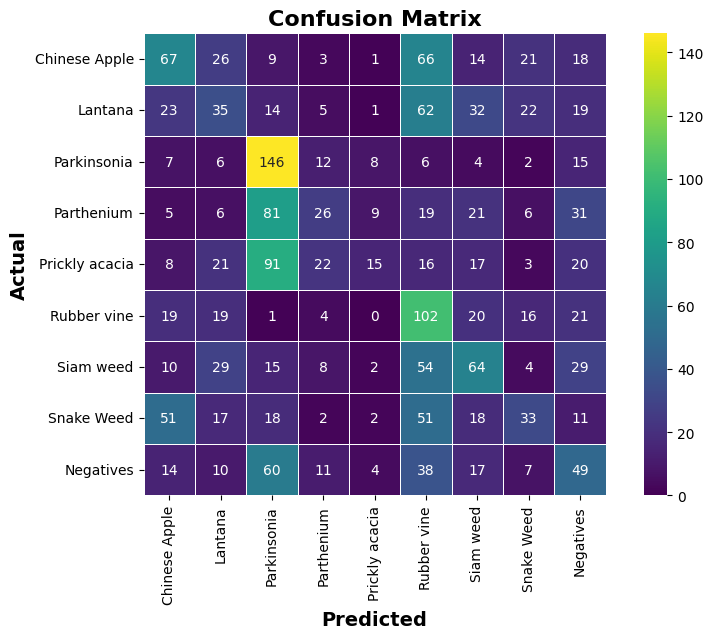


Confusion Matrix:
 [[ 67  26   9   3   1  66  14  21  18]
 [ 23  35  14   5   1  62  32  22  19]
 [  7   6 146  12   8   6   4   2  15]
 [  5   6  81  26   9  19  21   6  31]
 [  8  21  91  22  15  16  17   3  20]
 [ 19  19   1   4   0 102  20  16  21]
 [ 10  29  15   8   2  54  64   4  29]
 [ 51  17  18   2   2  51  18  33  11]
 [ 14  10  60  11   4  38  17   7  49]]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(10, 6))

sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
    yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()

### GradCAM Implementation

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/Users/ichaeyeon/Desktop/weed_classification/myenv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor_336']]. Received: the structure of inputs=*
  warnings.warn(


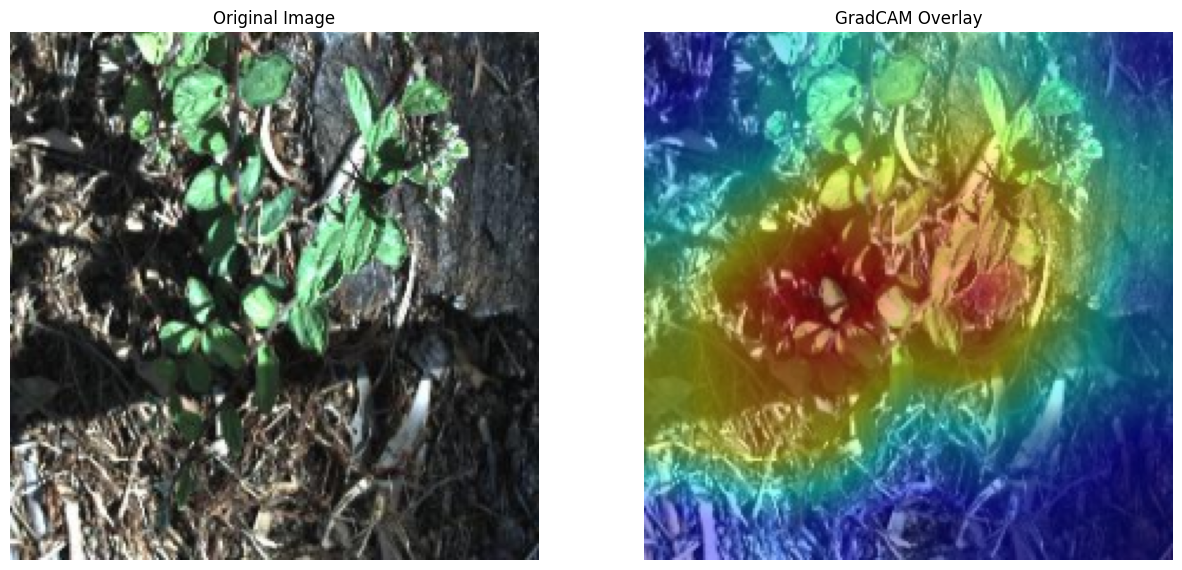

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # Automatically find the last convolutional layer if none is provided
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    
    def find_target_layer(self):
        # Find the last convolutional layer in the model
        for layer in reversed(self.model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):  # Check if the layer is Conv2D
                return layer.name
        raise ValueError("Could not find a Conv2D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # Build a model that maps the inputs to the activations of the last conv layer and the outputs
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output]
        )

        # Record operations for gradient computation
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # Compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # Compute guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # Average the gradients
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1, 2))
        
        # Compute the weighted sum of feature maps
        convOutputs = convOutputs[0]
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # Resize heatmap to match input image dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # Normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        # Apply colormap to heatmap
        heatmap = cv2.applyColorMap(heatmap, colormap)

        # Overlay heatmap on the image
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

def preprocess(img):
    # Resize to match the model's input dimensions
    img = cv2.resize(img, (224, 224))
    # Convert the image to RGB if needed (ensure 3 channels)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalize pixel values to [0, 1] or preprocess as per the model's requirements
    return img / 255.0  # Normalize to [0, 1]

# Example GradCAM Execution
test = cv2.imread("../images/20160928-140314-0.jpg")
test = cv2.resize(test, (224, 224))  # Ensure image is resized to model input dimensions
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

# Preprocess the test image
preprocessed_test = preprocess(test)
preprocessed_test = np.expand_dims(preprocessed_test, axis=0)

# Load your trained model (replace with your model)
model = tf.keras.Model(inputs, outputs, name="cnn_model")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy", "Precision", "Recall"])

# Predict the class of the test image
predictions = model.predict(preprocessed_test)
predicted_class = np.argmax(predictions[0])

# Initialize GradCAM
cam = GradCAM(model, predicted_class)
heatmap = cam.compute_heatmap(preprocessed_test)

# Overlay heatmap on the original image
(heatmap, output) = cam.overlay_heatmap(heatmap, test, alpha=0.6)

# Display the results
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(test / 255.0)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("GradCAM Overlay")
plt.axis("off")

plt.show()